# Qubit Protected by Two-Cooper-Pair Tunneling

In this notebook, we try to reproduce the result of the ["Superconducting circuit protected by two-Cooper-pair tunneling"](https://www-nature-com.stanford.idm.oclc.org/articles/s41534-019-0231-2) paper.

## Introdcution

[Smith2020](https://doi-org.stanford.idm.oclc.org/10.1038/s41534-019-0231-2)
designed a qubit that is protected by two Cooper-pair tunneling. We reproduced the main results of the paper such as
energy spectrum, wavefunctions, and matrix elements by use of SQcircuit. The diagram of the circuit is

<img src="pics/twoCPB_pic1.png" width="300" />

The circuit consists of four equal inductors with $E_L=2\text{GHz}$, two equal Josephson Junction with $E_J=15\text{GHz}$ and $E_{C_J}=2\text{GHz}$, and one shunt capacitor of $E_{C}=0.04\text{GHz}$.

## Circuit Description

Firstly, we import the SQcircuit and the relavant libraries

In [1]:
import os
os.chdir("..")

import SQcircuit as sq
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

We define the single inductive loop of the circuit via `Loop` class

In [2]:
loop1 = sq.Loop()

The elements of the circuit can be defined via `Capacitor`, `Inductor`, and `Junction` classes in SQcircuit, and to define the circuit, we use the `Circuit` class. 

In [3]:
# define the circuit’s elements
CJ = sq.Capacitor(2, 'GHz', Q=1e6)
Cshunt = sq.Capacitor(0.04, 'GHz')
# Cs = sq.Capacitor(1e-17, 'F')
L = sq.Inductor(2,'GHz', loops = [loop1])
JJ = sq.Junction(15,'GHz', loops = [loop1])
# define the circuit
circuitElements = {
    (0, 1): [L],
    (0, 2): [L],
    (1, 3): [CJ, JJ],
    (2, 4): [CJ, JJ],
    (3, 5): [L],
    (4 ,5): [L],
    (0, 5): [Cshunt]
}

cr = sq.Circuit(circuitElements, fluxDist="junction")

By creating an object of `Circuit` class, SQcircuit systematically finds the correct set of transformations and basis to make the circuit ready to be diagonalized. Since the author of the paper assianged the external flux distribution to the junctions, we set the the `fluxDist` argument to `"junction"` to produce the same result.

Before setting the truncation numbers for each mode and diagonalizing the Hamiltonian, we can gain more insight into our circuit by calling the `description()` method. This prints out which mode in SQcircuit is the charge mode or the harmonic mode with its natural frequency in GHz( the default unit). Moreover, it shows the prefactors in the Josephson junction part of the Hamiltonian $\tilde{\textbf{w}}_k$, which helps find the modes decoupled from the nonlinearity of the circuit.

In [4]:
cr.description()

mode_1: 	harmonic	freq=5567.0810875767065
mode_2: 	harmonic	freq=5567.081087576705
mode_3: 	harmonic	freq=4.079214182961373
mode_4: 	harmonic	freq=3.9999985618865486
mode_5: 	charge
w1: 	[ 0.  0.  1. -1.  1.]
w2: 	[0. 0. 1. 1. 1.]


The above output shows that `cr` circuit has four harmonic modes with one charge mode. From `w1` and `w2`, it becomes clear that the prefactor of the first and second mode is zero for both Josephson Junctions, which means that both modes are decoupled from the other modes. We can remove them by setting their truncation number to one.

To determine the size of the Hilbert space, we specify the truncation number for each circuit mode via `truncationNumbers()` method. Note that this is a necessary step before diagonalizing the circuit.

In [5]:
cr.truncationNumbers([1,1,17,17,17])

## Circuit Spectrum

To generate the spectrum of the circuit, firstly, we need to change and sweep the external flux of `loop1` by the `setFlux()` method. Then, we need to find the eigenfrequencies of the circuit that correspond to that external flux via `diag()` method. The following lines of code find the `spec` a 2D NumPy array so that each column of it contains the eigenfrequencies with respect to its external flux. 

In [6]:
# number of eigenvalues we aim for
numEig=6

# array that contains the spectrum
phi = np.linspace(-0.1,0.6,50)

# array that contains the spectrum
spec = np.zeros((numEig, len(phi)))

for i in range(len(phi)):
    # set the value of the flux external flux
    loop1.setFlux(phi[i])
    
    # diagonlize the circuit
    spec[:, i], _ = cr.diag(numEig)

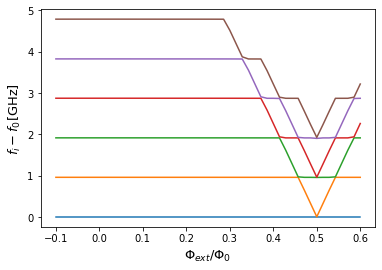

In [7]:
E_L = 2
E_C = 2
x=0.02
plt.figure()
for i in range(numEig):
    plt.plot(phi, (spec[i, :] - spec[0, :])/np.sqrt(16*x*(E_L/2)*E_C))

plt.xlabel("$\Phi_{ext}/\Phi_0$", fontsize=13)
plt.ylabel(r"$f_i-f_0$[GHz]", fontsize=13)
plt.show()

The next cell shows the spectrum from the figure 3a of the paper, which is the same spectrum that SQcircuit calculated.

<img src="pics/twoCPB_pic2.png" width="400" align = "left"/>

## Eigenfunctions

We can get the phase space eigenfunction of a specific eigenvector of a circuit by using the `eigPhaseSpace()` method. To calculate the eigenfunction at $\varphi_{ext} = 0.5\times2\pi$ similar to paper, we set back the flux of our loop to $0.5\times2\pi$ and diagonalize the `cr` again.

In [8]:
loop1.setFlux(0.5)
cr.truncationNumbers([1,1,17,17,17])
_, _ = cr.diag(numEig=5)

We generate the eigenfunction in the phase space by `eigPhaseCoordinate()` method for the first four eigen state of the circuit similar to the paper.

In [9]:
# create a range for each mode
phi1=0
phi2=0
phi3=0
phi4=np.linspace(-0.8,0.8,100)
phi5=np.pi*np.linspace(-1.5,2.5,100)
# creat the grid list
grid = [phi1, phi2, phi3, phi4, phi5]

# the ground state
state0 = cr.eigPhaseCoordinate(eigInd = 0, grid = grid)
    
# the first excited state
state1 = cr.eigPhaseCoordinate(eigInd = 1, grid = grid)

# the second excited state
state2 = cr.eigPhaseCoordinate(eigInd = 2, grid = grid)
    
# the third excited state
state3 = cr.eigPhaseCoordinate(eigInd = 3, grid = grid)

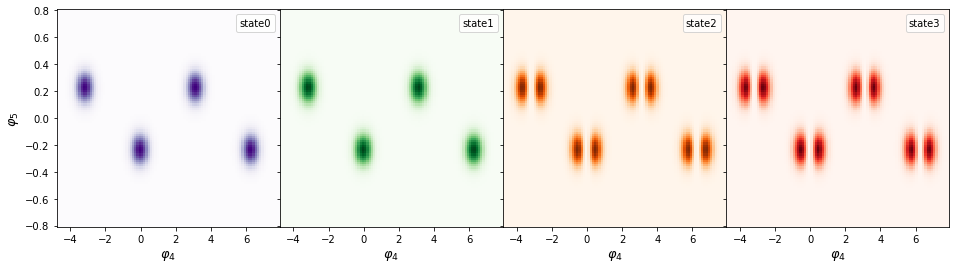

In [10]:
fig, axs = plt.subplots(1, 4,figsize=(16,4), sharey='row')
axs[0].pcolor(phi5, phi4, np.abs(state0.T)**2,cmap="Purples",shading='auto',label='state0')
axs[1].pcolor(phi5, phi4, np.abs(state1.T)**2,cmap="Greens",shading='auto',label='state1')
axs[2].pcolor(phi5, phi4, np.abs(state2.T)**2,cmap="Oranges",shading='auto',label='state2')
axs[3].pcolor(phi5, phi4, np.abs(state3.T)**2,cmap="Reds",shading='auto',label='state3')
for i in range(4):
    axs[i].set_xlabel(r"$\varphi_4$",fontsize=13)
    axs[i].legend(handletextpad=-0.1, handlelength=0.0)
axs[0].set_ylabel(r"$\varphi_5$",fontsize=13)
plt.subplots_adjust(wspace=0)

The next cell shows the eigenfunctions from the figure 3c of the paper, which is the same as what SQcircuit calculated.

<img src="pics/twoCPB_pic3.png" width="800" align = "left"/>

## Matrix Elements

[Smith2020](https://doi-org.stanford.idm.oclc.org/10.1038/s41534-019-0231-2) defined the normalized matrix element as a measure of degree of freedoms to which circuit can couple. For coupling operator $\mathcal{O}$ the normalized matrix element is

<img src="pics/twoCPB_pic4.png" width="220" align = "left"/>

where $|\psi\rangle$ is the eigenstates of the circuit and $|0o\rangle$ is the ground state. We calculate the normalized matrix element for inductive coupling to inductor between node 0 and node 2 using `cr.couplingOperator()` method.

In [11]:
numEig = 2
phi = np.linspace(0.46, 0.54, 1000)
# normalized matrix element
inductive_01 = np.zeros(len(phi))

for i in range(len(phi)):
    loop1.setFlux(phi[i])
    evals, estates = cr.diag(numEig)
    O = cr.couplingOperator("inductive", nodes=(2,0))
    norm = (estates[0].dag()*(O.dag()*O)*estates[0])[0].real
    inductive_01[i] =  np.abs((estates[0].dag()*O*estates[1])[0])**2/norm

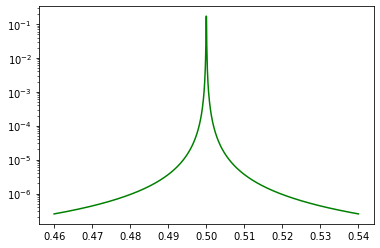

In [12]:
plt.semilogy(phi, inductive_01, 'green')

The next figure shows the same result from the figure 4a of the paper.

<img src="pics/twoCPB_pic5.png" width="300" align = "left"/>